In [1]:
# general import
import os
from pathlib import Path
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import copy
from collections import OrderedDict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
torch.set_default_dtype(torch.float32)

# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/home/ai/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/ai/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


# Network

It's easier if we wrap things in a class and then exploit pytorch functionalities

In [2]:
# utility to select and activation function

activations = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": F.relu,
    "linear": lambda x: x
}

def get_act(act_type):
    try:
        return activations[act_type]
    except:
        raise ValueError('Unknow activation function')

Define a class with a multi-layer perceptron (MLP), the dinosaur of deep learning

In [6]:
class MLP(nn.Module):
    def __init__(self,
                 nonlinearity = "tanh",
                 nls = [196, 5, 1]):
        
        super(MLP, self).__init__()
        self.nls = nls
        self.act = get_act(nonlinearity)
        # init some useful variables to be read from outside later
        self.N = nls[0]
        self.num_out = nls[-1]
        self.num_layers = len(nls) - 1
                
        # By wrapping network parameters in a Parameter object we tell nn.Module that those are trainable parameters
        self.layers = nn.ParameterList([]) # list of weights in each layer
        self.biases = nn.ParameterList([]) # list of biases in each layer
        for l in range(self.num_layers):
            nlpre, nlpost = nls[l], nls[l+1]
            layer = torch.randn((nlpre, nlpost)) / np.sqrt(nlpre) # init random (scaled) gaussian weights
            bias = nn.Parameter(torch.zeros(nlpost)) # init zero biases
            self.layers += [nn.Parameter(layer)]
            self.biases += [bias]
        
    def forward(self, x, drops=None):
        xs = [] # container for al activations in the network: unnecessary but interesting for later
        for l in range(self.num_layers-1):
            x = x @ self.layers[l] + self.biases[l] # apply weights and biases to previous layer activation
            x = self.act(x) # pass through non-linearity
            xs += [x] # store layer activation
        x = x @ self.layers[-1] + self.biases[-1] # linear readout layer
        return xs, x

Initialize the network object

In [7]:
nls = [100, 10, 10] # a list with the number of units in each layer (nls[0] is the input size)
nonlinearity = "tanh" # the activation function of the network

# init network object
net = MLP(nls=nls,
          nonlinearity=nonlinearity)

Let's inspect the content of the MLP class we created

In [8]:
for name, par in net.named_parameters():
    print(name, "with shape:")
    print(par.shape)

layers.0 with shape:
torch.Size([100, 10])
layers.1 with shape:
torch.Size([10, 10])
biases.0 with shape:
torch.Size([10])
biases.1 with shape:
torch.Size([10])


# Set learning parameters

First define some parameter for the training cycle

In [9]:
# set loss type
# loss_name = "mse" # mean squared error
loss_name = "ce" # cross entropy

batch_size = 1000 # number of input-output pairs in a batch
batch_size_test = 10000 # number of input-output pairs in a batch during testing
num_epochs = 100 # total number of epochs in the training cycle
test_every = 1 # will print test error every test_every epochs
optimizer = 'SGD' # optimization algorithm
lr = 1e-1 # learning rate ... usually 0.1 is OK
momentum = 0 # momentum during gradient descent

Then initialize the loss and connect the optimizer to the network weights and biases

In [10]:
# define loss object loss_fn (short for loss function)
if loss_name == "mse":
    loss_fn = torch.nn.MSELoss(reduction='mean')
elif loss_name == "ce":
    if net.num_out == 1: # for binary classification problem, it's good to use a single readout unit instead of two
        loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
    else:
        loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
else:
    raise ValueError("unknown loss")
    
# put all network parameters in to_train list and ...
to_train = net.parameters()

# ... pass it to the optimizer
if optimizer == 'SGD':
    opt = torch.optim.SGD(to_train, lr=lr, momentum=momentum)
elif optimizer == 'Adam':
    opt = torch.optim.Adam(to_train, lr=lr)
elif optimizer == 'RMSprop':
    opt = torch.optim.RMSprop(to_train, lr=lr)

# Put input-output pairs in dataloader

The first time you run this, it will download the MNIST dataset and resize it for faster training on a laptop

In [11]:
size = 10

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(size), # we'll go from 28 x 28 to 10 x 10 images
                                   transforms.ToTensor(),
                                   # numbers in the next line are the mean and std of MNIST pixels
                                   transforms.Normalize((0.1307,), (0.3081,)) 
                               ])),
    batch_size=batch_size,
    shuffle=True) # shuffle = True will produce a random input-output subseet at every call

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data',
                               train=False,
                               download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=False)

Watch the dataset

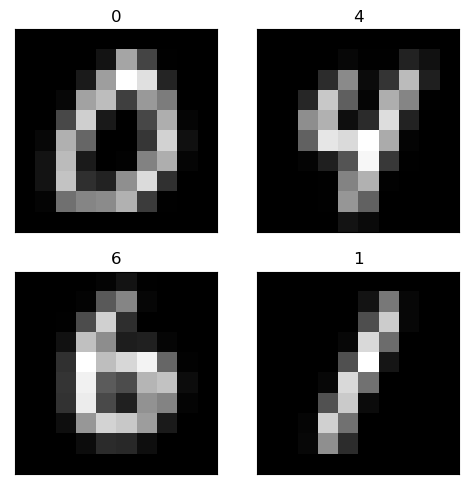

In [15]:
# extact data to watch
_, (X_to_plot, y_to_plot) = next(enumerate(train_loader))

cmap = 'gray'

nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
perm = np.random.randint(len(X_to_plot), size=len(X_to_plot))

count = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_title(str(y_to_plot[perm][count].item()))
        X = X_to_plot[perm][count][0] # WARNING: Images have an extra dimension for color channel
        ims = ax[i,j].imshow(X, cmap=cmap)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        count += 1
plt.tight_layout()

# Check untrained network on test data

Note that we need to reshape the data to a vector and also get rid of the additional dimension for color channel

In [16]:
_, (X_test, y_test) = next(enumerate(test_loader)) # extract the test set and keep it for later use

X_test.squeeze_(); # get rid of the second dimension
X_test = X_test.reshape(-1, net.N) # from a 10 x 10 matrix per data to a 100 vector
print("X_test size:", X_test.shape)

X_test size: torch.Size([10000, 100])


Now pass the whole test set through forward by just calling the network object on the tensor

In [17]:
with torch.no_grad():
    xs, out = net(X_test)

To test the initial network, let's write a test fuction (useful for later)

In [18]:
def test(net, X, y):
    with torch.no_grad():
        xs, out = net(X)

        # compute accuracy
        if net.num_out == 1:
            # for a single output we readout we can just check the sign of the output the network produced
            acc = ((2 * y - 1) * out[:,0] > 0).type(torch.float).sum().item()
        else:
            # the prediction is taken to be the readout unit with the biggest activation
            pred = out.argmax(dim=1)
            acc = pred.eq(y.view_as(pred)).sum().item()
    acc /= len(y)
    
    return acc

In [19]:
acc = test(net, X_test, y_test) # should be around 0.1 for an untrained network
print("accuracy:", acc)

accuracy: 0.1328


# Train

First off, we may want to store best results so let's write a utility fuction to extract network parameters to numpy.

In [20]:
def get_dict(net, to_numpy = True):
    if to_numpy:
        return OrderedDict(
            {k: v.detach().clone().to("cpu").numpy() for k, v in net.state_dict().items()}
        )
    else:
        return OrderedDict(
            {k: v.detach().clone().to("cpu") for k, v in net.state_dict().items()}
        )

Now we get serious and train the network on the task:

In [21]:
# init containers and variables
results = {}
eps_test = []
losses, losses_ep = [], []
errs_train, errs_test = [], []
accs_train, accs_test = [], []

best_acc_train, best_acc_test = 0., 0.
best_net_train, best_net_test = None, None

# utilities to measure time
start_time = time.time()
start_time_total = time.time()

# train
for ep in range(1, num_epochs+1):
 
    # init epoch
    net.train()
    loss_ep, acc_train = 0., 0.
    for batch_idx, (data, target) in enumerate(train_loader):
    
        data = data.squeeze().reshape(-1, net.N) # get rid of the color channel dimension and flatten the image

        # forward pass
        xs, out = net(data)
        loss = loss_fn(out, target)
        
        # backprop and update weights and biases
        opt.zero_grad()
        loss.backward()
        opt.step()

        # exit if NaN loss
        if np.isnan(loss.item()):
            raise ValueError("NaN happened")
    
        # compute acc train on the fly
        with torch.no_grad():
            if net.num_out == 1:
                acc_train += ((2 * target - 1) * out[:,0] > 0).type(torch.float).sum().item()
            else:
                pred = out.argmax(dim=1)
                acc_train += pred.eq(target.view_as(pred)).sum().item()

        # record loss
        loss_ep += loss.item() * len(data)
        losses += [loss.item()]

    # record loss & acc
    loss_ep /= len(train_loader.dataset)
    acc_train /= len(train_loader.dataset)

    losses_ep += [loss_ep]
    accs_train += [acc_train]

    # compute err & test
    acc_test = np.nan
    if ep % test_every == 0:
        # measure time & print
        elapsed_time = time.time() - start_time
        start_time = time.time()
        eps_test += [ep]
        toprint = 'ep: {} time: {:.2f} Loss: {:.4f}'.format(ep, elapsed_time/60, loss_ep)
        toprint += ' t: {:.4f}'.format(acc_train)

        # check if train accuracy improved
        improved_train = acc_train > best_acc_train
        if improved_train:
            best_acc_train = acc_train
            best_net_train = get_dict(net)

        # test
        acc_test = test(net, X_test, y_test) # test the network
        toprint += ' g: {:.4f}'.format(acc_test)
        accs_test += [acc_test]
        # check if test test accuracy improved
        improved_test = acc_test > best_acc_test
        if improved_test:
            best_acc_test = acc_test
            best_net_test = get_dict(net)

        # print if improved
        if improved_train:
            toprint += u' \u2191'
        if improved_test:
            toprint += u' *'

        print(toprint)
        
#     # you might want to exit when all training set has been learned
#     if acc_train > 1.:
#         print('max acc_train -> exiting')
#         break

elapsed_time = time.time() - start_time_total
print("done")
print("elapsed:", str(datetime.timedelta(seconds=elapsed_time)))

ep: 1 time: 0.12 Loss: 1.6264 t: 0.5448 g: 0.6687 ↑ *
ep: 2 time: 0.12 Loss: 1.0776 t: 0.7191 g: 0.7737 ↑ *


KeyboardInterrupt: 

Let's look at the loss during training

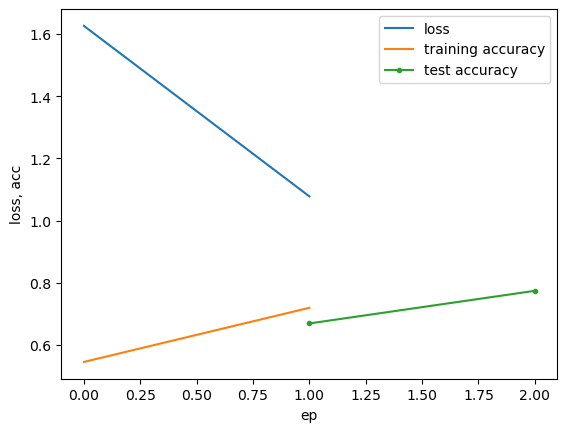

In [22]:
plt.plot(losses_ep, label="loss");
plt.plot(accs_train, label="training accuracy");
plt.plot(eps_test, accs_test, '.-', label="test accuracy");
plt.xlabel("ep");
plt.ylabel("loss, acc")
plt.legend();

# How to use dataloaders to generate your own task

When you come up with a task you may want to define your own data. The easiest is of course a random input-output task:

In [23]:
num_train = 1000
N = 100

X_train = torch.randn(num_train, N)
y_train = 2. * torch.randint(2, size=(num_train,)) - 1.

And wrap your dataset in a dataloader (note that a test set wouldn't make sense for the particular case of a random task)

In [24]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=10,
                                           shuffle=True,
                                           num_workers=0,
                                           pin_memory=True)

Show the data and target for a batch

labels: tensor([ 1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.])


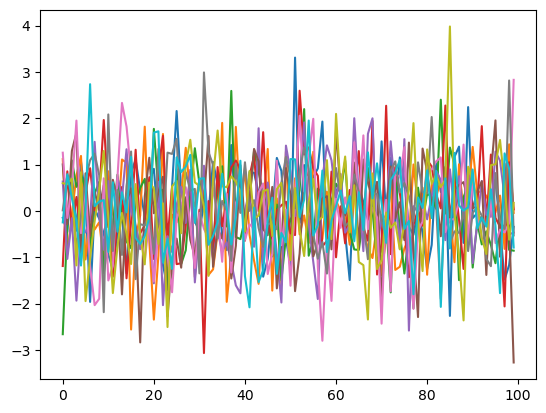

In [25]:
_, (data, target) = next(enumerate(train_loader))

plt.plot(data.T);
print("labels:", target)